 # This is to predict IRAC Ch1 flux with SOM:
 
 added by Shooby, Oct 10th, 2019 <br>

In [21]:
import numpy as np
import scipy.ndimage
import scipy.interpolate
import scipy.optimize as so
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from SOMPY import sompy
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab

import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

In [22]:
##Interpolate to remove empty cells
def surakh(m):
    mask = ~(np.isnan(m))
    xx, yy = np.meshgrid(np.arange(np.shape(m)[1]), np.arange(np.shape(m)[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T
    data0 = np.ravel( m[mask] )
    interp0 = scipy.interpolate.NearestNDInterpolator( xym, data0 )
    result0 = interp0(np.ravel(xx), np.ravel(yy)).reshape( xx.shape )
    return result0


def mag2flux(mag):
    return 10.0**((23.9-mag)/2.5)
def flux2mag(flux):
    return -2.5*(np.log10(flux))+23.9 

In [36]:
a=pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
b = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gdn.fits')
print(len(a['Photo_z']),len(b['zbest']))

(34930, 35445)


In [30]:
def col(m1,m2):
    m1,m2 = flux2mag(m1),flux2mag(m2)
    c=np.zeros_like(m1)
    for i in range(len(m1)):
        if (10<m1[i]<40)& (10<m2[i]<40):
            c[i]=m1[i]-m2[i]
        else:        
            c[i]=99.
    return c


bv=col(a['ACS_F435W_FLUX'],a['ACS_F606W_FLUX'])
vi=col(a['ACS_F606W_FLUX'],a['ACS_F775W_FLUX'])
iz=col(a['ACS_F775W_FLUX'],a['ACS_F850LP_FLUX'])
zy=col(a['ACS_F850LP_FLUX'],a['WFC3_F098M_FLUX'])
yj=col(a['WFC3_F098M_FLUX'],a['WFC3_F125W_FLUX'])
jh=col(a['WFC3_F125W_FLUX'],a['WFC3_F160W_FLUX'])
hch1=col(a['WFC3_F160W_FLUX'],a['IRAC_CH1_FLUX'])

mi=-2.5
ma=3.5


sel=(bv>=mi)&(bv<=ma)&(vi>=mi)&(vi<=ma)&(iz>=mi)&(iz<=ma)&(zy>=mi)&(zy<=ma)&(yj>=mi)&(yj<=ma)&(jh>=mi)&(jh<=ma)&(hch1>=mi)&(hch1<=ma) & (a['Photo_z']<2.5)

dat=np.array([bv[sel],vi[sel],iz[sel],zy[sel],yj[sel],jh[sel],hch1[sel]])
red=a['Photo_z'][sel]
data=dat.T
spec=a['Spec_z'][sel]
specq=a['Spec_z_dq'][sel]
iband=a['ACS_F775W_FLUX'][sel]


print(len(red))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


6353


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [31]:
## Multi-dimensional data is: colors of lensing galaxy SEDs in LSST+WFIRST filters
dat=np.array([bv[sel],vi[sel],iz[sel],zy[sel],yj[sel],jh[sel],hch1[sel]])
data=dat.T
## Training a SOM with PCA initalization
msz0 = 50
msz1 = 40
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.027000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.146000, quantization error: 1.814764

 epoch: 2 ---> elapsed time:  0.122000, quantization error: 1.595905

 epoch: 3 ---> elapsed time:  0.112000, quantization error: 1.441541

 epoch: 4 ---> elapsed time:  0.107000, quantization error: 1.377692

 epoch: 5 ---> elapsed time:  0.109000, quantization error: 1.330468

 epoch: 6 ---> elapsed time:  0.119000, quantization error: 1.284292

 epoch: 7 ---> elapsed time:  0.117000, quantization error: 1.239195

 epoch: 8 ---> elapsed time:  0.200000, quantization error: 1.191616

 epoch: 9 ---> elapsed time:  0.168000, quantization error: 1.139903

 epoch: 10 ---> elapsed time:  0.120000, quantization error: 1.080230

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 13

 epoch: 1 ---> elapsed time:  0.113000, quantization error: 1.006787

 

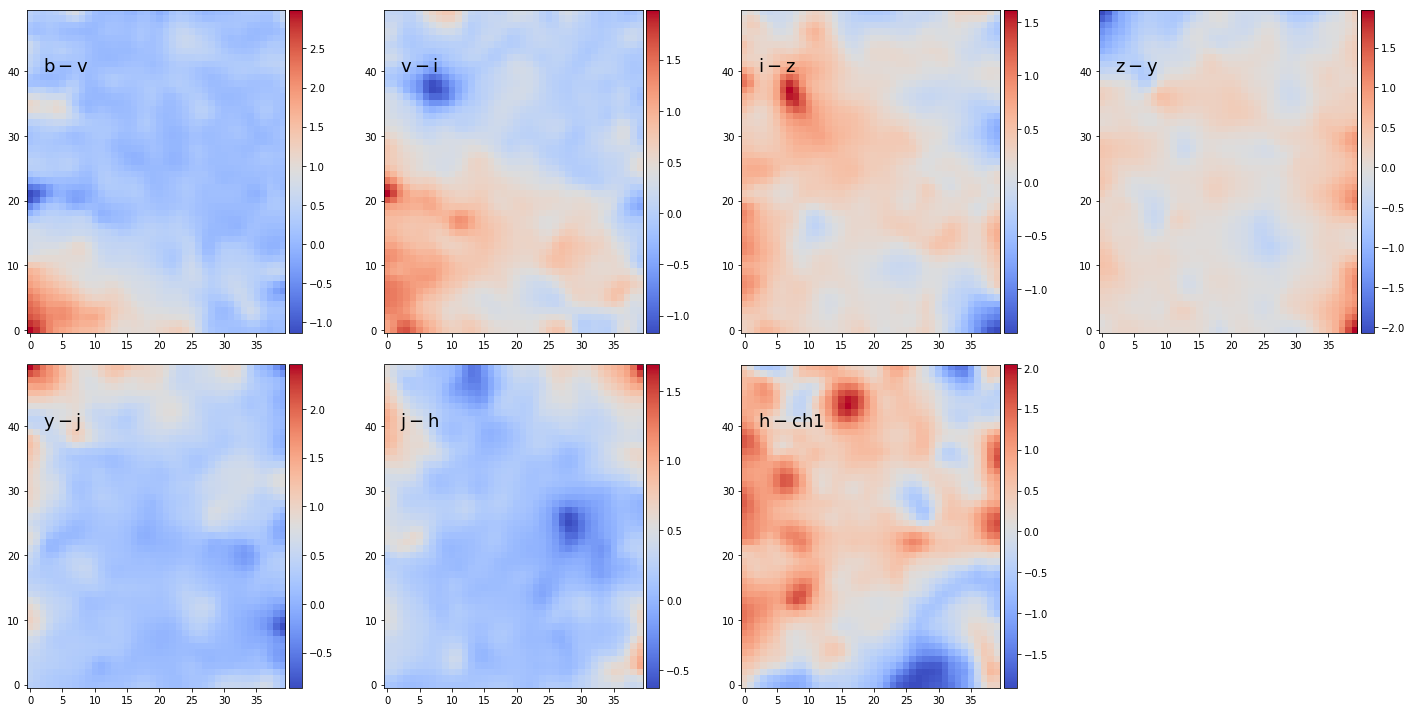

In [32]:
somcol=np.zeros(8,object)
plt.figure(figsize=(20,10))
colors=[r'$\rm b-v$',r'$\rm v-i$',r'$\rm i-z$',r'$\rm z-y$',r'$\rm y-j$',r'$\rm j-h$',r'$\rm h-ch1$']
codebook = sm._normalizer.denormalize_by(sm.data_raw,sm.codebook.matrix)
    
for ind in range(0,4):
    mp = codebook[:, ind].reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])
    plt.subplot(2,4,ind+1)
    ax = plt.gca()
    im=ax.imshow(mp,origin='lower',cmap='coolwarm')
    somcol[ind]=np.ndarray.flatten(mp)
    #ax.axis('off')
    plt.text(2,msz0-10,str(colors[ind]),size=18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
for ind in range(4,7):
    mp = codebook[:, ind].reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])
    plt.subplot(2,4,ind+1)
    ax = plt.gca()
    im=ax.imshow(mp,origin='lower',cmap='coolwarm')
    somcol[ind]=np.ndarray.flatten(mp)
    #ax.axis('off')
    plt.text(2,msz0-10,str(colors[ind]),size=18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()


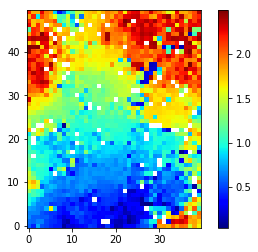

In [33]:
def rms(a):
    return np.sqrt(np.mean(np.square(a)))

a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
    
med_r=np.zeros([msz0,msz1])

for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.median(red[unja]))
plt.imshow(med_r,origin='lower',cmap='jet')
plt.colorbar()

In [56]:
nbv=col(b['ACS_F435W_FLUX'],b['ACS_F606W_FLUX'])
nvi=col(b['ACS_F606W_FLUX'],b['ACS_F775W_FLUX'])
niz=col(b['ACS_F775W_FLUX'],b['ACS_F850LP_FLUX'])
nzy=col(b['ACS_F850LP_FLUX'],b['WFC3_F105W_FLUX'])
nyj=col(b['WFC3_F105W_FLUX'],b['WFC3_F125W_FLUX'])
njh=col(b['WFC3_F125W_FLUX'],b['WFC3_F160W_FLUX'])
nhch1=col(b['WFC3_F160W_FLUX'],b['IRAC_CH1_SCANDELS_FLUX'])

mi=-2.5
ma=3.5


sel=(nbv>=mi)&(nbv<=ma)&(nvi>=mi)&(nvi<=ma)&(niz>=mi)&(niz<=ma)&(nzy>=mi)&(nzy<=ma)&(nyj>=mi)&(nyj<=ma)&(njh>=mi)&(njh<=ma)&(nhch1>=mi)&(nhch1<=ma) & (b['zbest']<2.5)
jflux = b['WFC3_F125W_FLUX'][sel]
hflux = b['WFC3_F160W_FLUX'][sel]
ch1flux = b['IRAC_CH1_SCANDELS_FLUX'][sel]

ndat=np.array([nbv[sel],nvi[sel],niz[sel],nzy[sel],nyj[sel],njh[sel]])
nred=b['zbest'][sel]
ndata=ndat.T


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [57]:
y = sm.predict(ndata)

In [60]:
ch1,ch1_linear = np.zeros_like(hflux),np.zeros_like(hflux)
for boz in range(len(y)):
    ch1[boz] = mag2flux(flux2mag(hflux[boz])-y[boz])
    ch1_linear[boz] = (hflux[boz]-jflux[boz])*((350-160)/(160-125))+hflux[boz]

(0, 150)

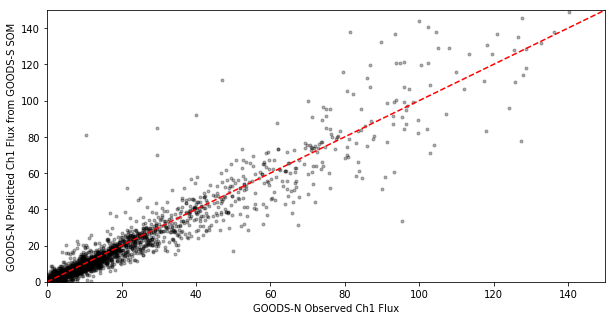

In [74]:
plt.figure(figsize=(10,5))
plt.plot(ch1flux,ch1,'k.',alpha=0.3)
plt.plot([0,300],[0,300],'r--')
plt.xlabel('GOODS-N Observed Ch1 Flux')
plt.ylabel('GOODS-N Predicted Ch1 Flux from GOODS-S SOM')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(10**-2,10**3)
#plt.ylim(10**-2,10**3)
plt.xlim([0,150])
plt.ylim([0,150])


### What about linear extrapolation from JH to ch1 (Eric suggestion)

(0, 150)

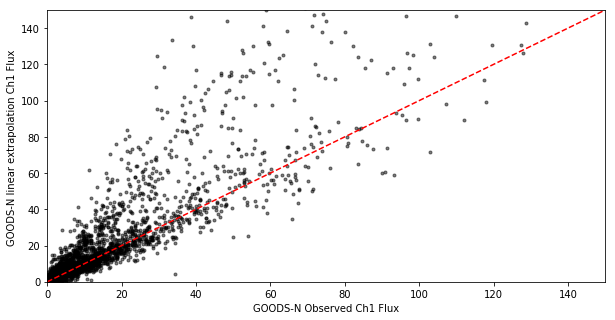

In [76]:
plt.figure(figsize=(10,5))
plt.plot(ch1flux,ch1_linear,'k.',alpha=0.5)

plt.plot([0,300],[0,300],'r--')
plt.xlabel('GOODS-N Observed Ch1 Flux')
plt.ylabel('GOODS-N linear extrapolation Ch1 Flux ')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(10**-2,10**3)
#plt.ylim(10**-2,10**3)
plt.xlim([0,150])
plt.ylim([0,150])